In [1]:
import itertools
from sklearn.linear_model import LinearRegression
from convergence_helpers import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gaussian_mixture_grid import GaussianMixtureGrid
import numpy as np
from figure_grid import *
import pickle
from scipy.misc import comb

In [2]:
def conv_line(index, errors, burnin=100):
  start = np.argwhere(index > burnin)[0][0]
  lg_ery = np.log10(errors[start:])
  lg_idx = np.log10(index[start:]).reshape((len(lg_ery), 1))
  lreg = LinearRegression()
  lreg.fit(lg_idx, lg_ery)
  score = lreg.score(lg_idx, lg_ery)
  return lreg.coef_[0], lreg.intercept_, score

def conv_lines(chains, grid, p=1, thin_fac=100):
  thin = int(np.ceil(comb(len(chains),p)/thin_fac))
  print(p, thin)
  return [
      conv_line(*joint_conv_trace(chain, grid))
      for i, chain in enumerate(itertools.combinations(chains, p)) if i % thin == 0]

def speedups(intercepts):
  return [intercepts[0]/intercepts[i] for i in range(len(intercepts))]

Load our samples -- 16 independent runs of the 50,000-element chain for each method.

In [3]:
grid = pickle.load(open('./9d-grid.pkl', 'rb'))
m_hs = pickle.load(open('./9d-metropolis-16x.pkl', 'rb'))
rejs = pickle.load(open('./9d-rejection-16x.pkl', 'rb'))
tels = pickle.load(open('./9d-teleport-16x.pkl', 'rb'))

In [4]:
ps = list(range(1, len(rejs)+1))
ps

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

For each method, we're going to combine different numbers of the chains and do a linear fit to the log-log results (which will have slope of about -0.5). This will allow us to predict the time until we have estimated the mean with a particular precision, even if we never actually sampled enough to get there. We can also use the intercepts to compute the speedup!

To make the results fair, we're going to take averages across multiple ways of combining parallel chains (e.g. for p=2, compute convergence for the 1st and 2nd, 1st and 3rd, 2nd and 3rd, etc.). Because the combinatorial complexity blows up, we're going to limit it to 100 such combinations per number (so our results will be most fair near the edges).

In [69]:
rej_lines = [conv_lines(rejs, grid, p, 100) for p in ps]

1 1
2 2
3 6
4 19
5 44
6 81
7 115
8 129
9 115
10 81
11 44
12 19
13 6
14 2
15 1
16 1


In [ ]:
m_h_lines = [conv_lines(m_hs, grid, p, 100) for p in ps]

1 1
2 2
3 6


In [5]:
tel_lines = [conv_lines(tels, grid, p, 100) for p in ps]

1 1


/Users/asross/.pyenv/versions/3.5.1/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


2 2
3 6
4 19
5 44
6 81
7 115
8 129
9 115
10 81
11 44
12 19
13 6
14 2
15 1
16 1


The first time I ran this I pickled the results because it takes a long time.

In [8]:
m_h_lines2 = pickle.load(open('./9d-metropolis-fits.pkl', 'rb'))
rej_lines2 = pickle.load(open('./9d-rejection-fits.pkl', 'rb'))
tel_lines2 = pickle.load(open('./9d-teleportation-fits.pkl', 'rb'))

Let's make sure the slopes are roughly around -0.5 (corresponding to $1/\sqrt{N}$) and that the R^2 scores are ok:

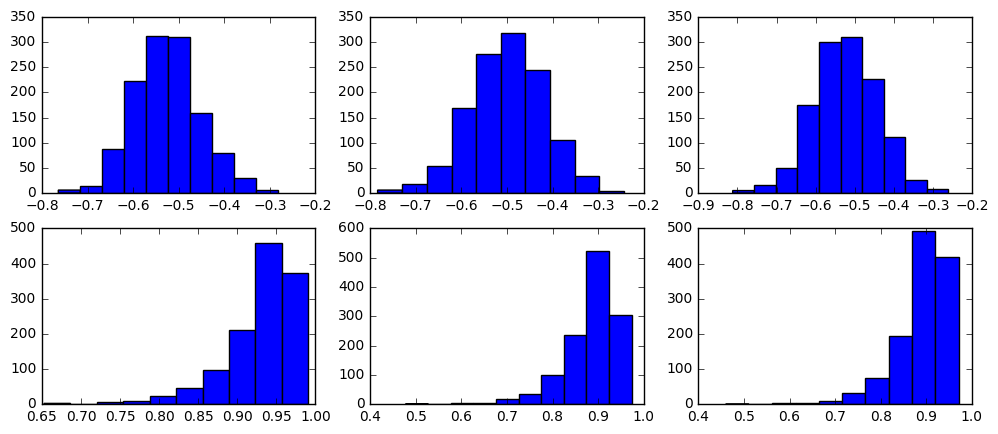

In [27]:
def slopes(lines):
  s = []
  for l in lines: s += [ll[0] for ll in l]
  return s

def r2scores(lines):
  r = []
  for l in lines: r += [ll[2] for ll in l]
  return r

plt.figure(figsize=(12,5))

plt.subplot(231); plt.hist(slopes(m_h_lines2))
plt.subplot(232); plt.hist(slopes(rej_lines2))
plt.subplot(233); plt.hist(slopes(tel_lines2))
plt.subplot(234); plt.hist(r2scores(m_h_lines2))
plt.subplot(235); plt.hist(r2scores(rej_lines2))
plt.subplot(236); plt.hist(r2scores(tel_lines2))

plt.show()

Alright, that looks reasonable; we get a mode of -0.5 and most R^2 scores around 0.9.

Let's now use our "linear" (power-law) fits to plot times til certain precisions and also compute speedups by comparing intercepts:

In [9]:
def plot_errtime(lines, label, tol=0.1):
  ps = list(range(1, len(lines)+1))
  inters = [[10**((tol-l[1])/l[0]) for l in ll] for ll in lines]
  means = [np.mean(ins) for ins in inters]
  plt.plot(ps, means, lw=3, label=label)

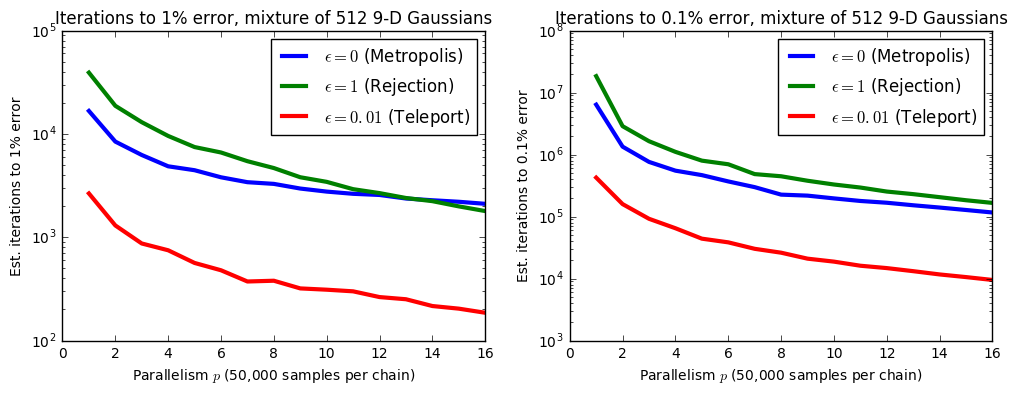

In [32]:
plt.figure(figsize=(12,4))

plt.subplot(121)

plt.title('Iterations to 1% error, mixture of 512 9-D Gaussians')
plot_errtime(m_h_lines2, r'$\epsilon=0$ (Metropolis)', 1.08)
plot_errtime(rej_lines2, r'$\epsilon=1$ (Rejection)', 1.08)
plot_errtime(tel_lines2, r'$\epsilon=0.01$ (Teleport)', 1.08)
plt.ylabel('Est. iterations to 1% error')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Parallelism $p$ (50,000 samples per chain)')

plt.subplot(122)

plt.title('Iterations to 0.1% error, mixture of 512 9-D Gaussians')
plot_errtime(m_h_lines2, r'$\epsilon=0$ (Metropolis)', 0.108)
plot_errtime(rej_lines2, r'$\epsilon=1$ (Rejection)', 0.108)
plot_errtime(tel_lines2, r'$\epsilon=0.01$ (Teleport)',0.108)
plt.ylabel('Est. iterations to 0.1% error')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Parallelism $p$ (50,000 samples per chain)')
plt.show()

So, it looks like rejection sampling has better scaling (which is obvious in the 1% case where it actually overtakes MH), but is initially less efficient, which makes sense; it's an unbiased sampler but we reject most points. Teleportation is just way ahead.

Let's compare speedups using the intercepts:

In [11]:
def intercept_speedups(lines):  
  inters = [[10**l[1] for l in ll] for ll in lines]
  means = [np.mean(ins) for ins in inters]
  return speedups(means)

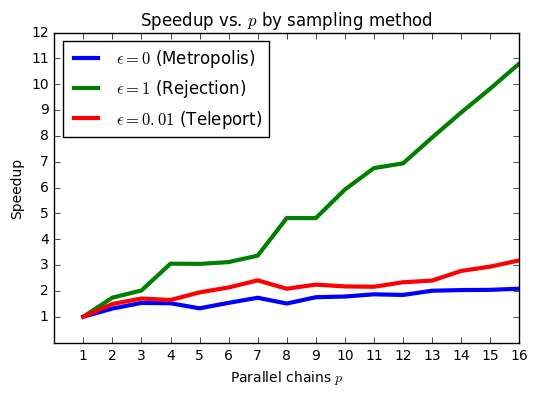

In [36]:
plt.plot(ps, intercept_speedups(m_h_lines2), label=r'$\epsilon=0$ (Metropolis)', lw=3)
plt.plot(ps, intercept_speedups(rej_lines2), label=r'$\epsilon=1$ (Rejection)', lw=3)
plt.plot(ps, intercept_speedups(tel_lines2), label=r'$\epsilon=0.01$ (Teleport)', lw=3)
plt.legend(loc='best')
plt.ylabel('Speedup')
plt.xlabel('Parallel chains $p$')
plt.xticks(ps)
plt.yticks(ps[:12])
plt.title('Speedup vs. $p$ by sampling method')
plt.show()

So rejection sampling has near-perfect speedup, which makes sense given how unbiased it is, and Metropolis does extremely poorly, barely reaching a speedup of 2 with 16 chains.

Teleportation doesn't have perfect scaling, but it's definitely better; even with only a 0.01 chance of teleporting, our speedup is 1.5x better.

There is likely some theoretical way to characterize this based on an analysis similar to PageRank.